<center>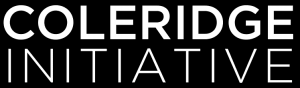</center>             


<h1><center>Coleridge: Start To End</center></h1>
<h3><center>In this notebook I will drive you through all the important steps required to understand and complete this competition. <center></h3>

<h4><center>First Understand What is Coleridge Initiative?</center></h4>
<ul>
<li>The Coleridge Initiative is a not-for-profit organization, originally established at New York University, that is working with governments to ensure that data are more effectively used for public decision-making</li>
<p></p>
<li>To achieve this goal Coleridge Initiative is working with government agencies to create value for the taxpayer from the careful use of data, by building new technologies to enable secure access to and sharing of confidential microdata, and by training agency staff to acquire modern data skills.</li>
</ul>




<h4> <center>Competition Goal</center> </h4>
In this competition, we need to develop an algorithm using natural language processing (NLP) to automate the discovery of how scientific data is referenced in publications. We have to identify the data sets that publications authors used in their work. For this we have full text of scientific publications from numerous research areas.
This model will eventually enable government agencies and researchers to quickly find the information they need. The approach will be used to develop data usage scorecards to better enable agencies to show how their data are used and bring down a critical barrier to the access and use of public data.
<p></p>
<b>In short, we have to build a model to identify what are the datasets that a publication is using.</b>



<h4><center>Let's understand the DATA (EDA)</center></h4>
<p></p>
<b>Files Provided</b>
<ul>
    <li><b>train.csv-</b> CSV file contains metadata of the publications</li>
    <li><b>train-</b>JSON file contains publications that are referenced in train.csv</li>
    <li><b>test-</b>CSV file contains publications for testing purpose</li>
    <li><b>sample_submission.csv-</b>CSV file conatins publications IDs column and prediction columns</li>
</ul>

In [ ]:
#Libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import re
import json
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm.autonotebook import tqdm
from functools import partial
from wordcloud import WordCloud, STOPWORDS
import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from nltk.probability import FreqDist


<b>Train Data Exploration</b>

In [ ]:
train = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
train.head()

In [ ]:
train.columns

<h3><b>Data Description</b></h3>
<p></p>
<ul>
    <li><b>id-</b> publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.</li>
    <li><b>pub_title-</b>title of the publication (a small number of publications have the same title).</li>
    <li><b>dataset_title-</b>the title of the dataset that is mentioned within the publication.</li>
    <li><b>dataset_label-</b>a portion of the text that indicates the dataset.</li>
    <li><b>cleaned_label-</b>the dataset_label, as passed through the clean_text function from the Evaluation page.</li>
</ul>

In [ ]:
train.info()

<b>So we have no 'NULL' values in the train data</b>

In [ ]:
for col in train.columns:
    print(col + ":" + str(len(train[col].unique())))

<h4>Inference</h4>


- The Training Dataset has 19,661 samples but only 14,316 unique IDs in the dataset. This means that some publications include a multitude of datasets. 


- The pub_title unique count is also less than the Id unique counts. This points to the precense of several occurences of having 2 separate publications, each with a unique ID, but sharing the exact same title.


- Also, there are a total of 45 unique dataset_title and 130 unique dataset_label. It means that a single dataset could have multible labels throughout different publications.

<b>Sample Submission</b>

In [ ]:
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
sample_sub.head()

<h3><b>Data Description</b></h3>
<p></p>
<ul>
    <li><b>id-</b> publication id </li>
    <li><b>PredictionString-</b>To be filled with equivalent of cleaned_label of train data..</li>
    
</ul>

<h3><b>Data Processing</b></h3>

<b>Now we will create a function to get the text from the JSON file and append it to the new column in table</b>

In [ ]:
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [ ]:
def json_to_text(filename, train_files_path=train_files_path, output='text'):
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [ ]:
tqdm.pandas()
train['text'] = train['Id'].progress_apply(json_to_text)

<b>Let's see the Train Data now</b>

In [ ]:
train.head()

<b>Now apply the function to submission Data</b>

In [ ]:
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(json_to_text, train_files_path=test_files_path))

In [ ]:
sample_sub.head()

<b>Create a function to Preprocess the data using Basic NLP Filters (all text to lower case, Removes special charecters, emojis and multiple spaces)</b>

In [ ]:
def text_cleaning(text):
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [ ]:
tqdm.pandas()
train['text'] = train['text'].progress_apply(text_cleaning)

<h3><center>EDA with Visualization</h3>

In [ ]:
text = ' '.join(train['text'].sample(frac=0.3))
wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, width=2000, height=1200).generate(text)

barplot_dim = (15, 15)
ax = plt.subplots(figsize=barplot_dim, facecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top 100 Most Common Words in Publications Text', fontsize=50)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


<h3><b>Baseline Model</b></h3>

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()
temp_1 = [x.lower() for x in train['dataset_label'].unique()]
temp_2 = [x.lower() for x in train['dataset_title'].unique()]
temp_3 = [x.lower() for x in train['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
lables_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train[train['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

In [ ]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['PredictionString'] = lables_list

In [ ]:
submission.head()

<b>Currently working on BERT model for this competition for better results. Hopefully share with you soon. Thank You!!</b>

<h3>References</h3>


https://www.kaggle.com/ishandutta/coleridge-complete-eda-in-one-notebook

https://www.kaggle.com/harshsharma511/starter-competition-data-eda-and-modelling

https://www.kaggle.com/harshsharma511/starter-competition-data-eda-and-modelling

https://www.kaggle.com/harshsharma511/coleridge-initiative-eda-baseline-model